In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np 
import pandas as pd 

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import tensorflow as tf
import keras
from keras import Sequential

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Input,Flatten,Dense,BatchNormalization,Activation,Dropout,GlobalAveragePooling2D,MaxPooling2D,RandomFlip,RandomZoom,RandomRotation

In [ ]:
from keras.datasets import cifar10

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
(x_train, y_train), (x_val, y_val) = cifar10.load_data()

y_train=to_categorical(y_train)
y_val=to_categorical(y_val)

print((x_train.shape, y_train.shape))
print((x_val.shape, y_val.shape))

170508288/170498071 [==============================] - 13s 0us/step
((50000, 32, 32, 3), (50000, 10))
((10000, 32, 32, 3), (10000, 10))


In [ ]:
base_model = ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
data_augmentation = Sequential(
    [RandomFlip("horizontal"), 
     RandomRotation(0.1),
     RandomZoom(0.1)]
)

In [ ]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
outputs = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              209817

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 5
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size = 64, epochs=epochs)

Epoch 1/5
782/782 [==============================] - 543s 668ms/step - loss: 0.6919 - accuracy: 0.7692 - val_loss: 0.3299 - val_accuracy: 0.8863
Epoch 2/5
782/782 [==============================] - 522s 667ms/step - loss: 0.2305 - accuracy: 0.9243 - val_loss: 0.2532 - val_accuracy: 0.9134
Epoch 3/5
782/782 [==============================] - 522s 667ms/step - loss: 0.1229 - accuracy: 0.9596 - val_loss: 0.2226 - val_accuracy: 0.9255
Epoch 4/5
782/782 [==============================] - 521s 667ms/step - loss: 0.0630 - accuracy: 0.9808 - val_loss: 0.2336 - val_accuracy: 0.9250
Epoch 5/5
782/782 [==============================] - 522s 667ms/step - loss: 0.0291 - accuracy: 0.9933 - val_loss: 0.2280 - val_accuracy: 0.9337


In [ ]:
def plot_history(history):
    history_frame = pd.DataFrame(history.history)
    history_frame.loc[:, ['loss', 'val_loss']].plot()
    history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()
    
    return

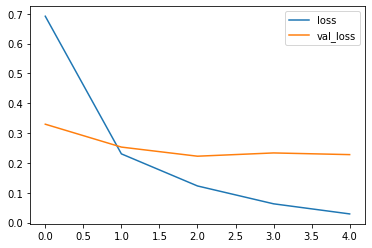

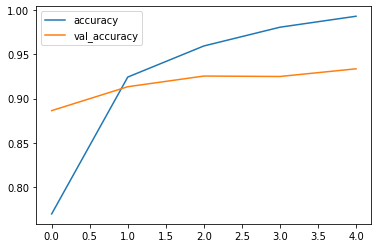

In [ ]:
plot_history(history)

In [ ]:
model.save("ResNet50_CIFAR-10.h5")

[[Text(0, 0.5, 'airplane'),
  Text(0, 1.5, 'automobile'),
  Text(0, 2.5, 'bird'),
  Text(0, 3.5, 'cat'),
  Text(0, 4.5, 'deer'),
  Text(0, 5.5, 'dog'),
  Text(0, 6.5, 'frog'),
  Text(0, 7.5, 'horse'),
  Text(0, 8.5, 'ship'),
  Text(0, 9.5, 'truck')],
 [Text(0.5, 0, 'airplane'),
  Text(1.5, 0, 'automobile'),
  Text(2.5, 0, 'bird'),
  Text(3.5, 0, 'cat'),
  Text(4.5, 0, 'deer'),
  Text(5.5, 0, 'dog'),
  Text(6.5, 0, 'frog'),
  Text(7.5, 0, 'horse'),
  Text(8.5, 0, 'ship'),
  Text(9.5, 0, 'truck')]]

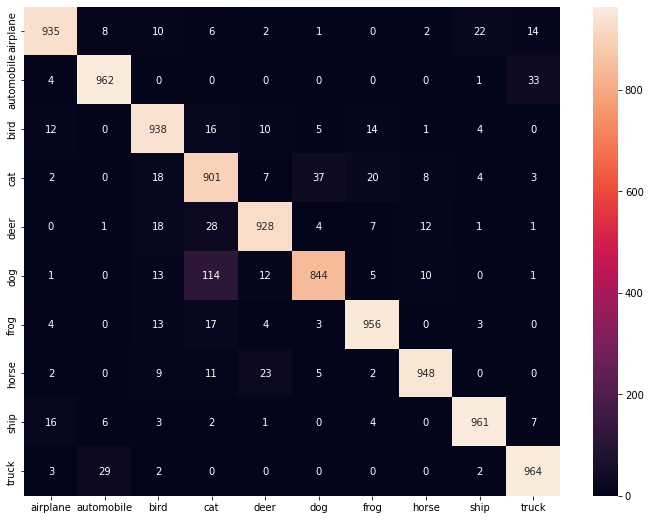

In [ ]:
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

predictions=model.predict(x_val)

y_pred_classes = np.argmax(predictions, axis=1)
y_true = np.argmax(y_val, axis=1)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 9))
c = sns.heatmap(confusion_mtx, annot=True, fmt='g')
c.set(xticklabels=class_names, yticklabels=class_names)

In [ ]:
score = model.evaluate(x_train, y_train, verbose=0) 
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.01590101234614849 / Test accuracy: 0.9965599775314331
